## LangGraph Tool Bindings & Agent Creation Tutorial

This notebook demonstrates advanced agent concepts: **tool binding**, **custom tool creation**, and **conditional execution** using LangGraph's StateGraph architecture.

### Core Concepts:
- **Tool Binding**: Connecting LLMs with external functions and APIs
- **Custom Tools**: Creating domain-specific capabilities for agents
- **Conditional Edges**: Dynamic workflow routing based on agent decisions
- **ToolNode**: LangGraph's built-in tool execution handler

### What You'll Build:
A sophisticated agent that can search the web, perform mathematics, and route between different capabilities based on user queries.

## Environment Setup for Advanced Agents

Install packages for building sophisticated tool-enabled agents with conditional logic and state management.

In [ ]:
# !pip install -q langchain langchain-community langgraph openai langchain_openai

## Core Imports and Dependencies

Import essential components for building stateful agents:
- **StateGraph**: Core orchestration for complex workflows
- **ToolNode & tools_condition**: Built-in tool execution and routing logic  
- **add_messages**: Message accumulation function for conversation state
- **MessagesState**: Pre-defined state structure for chat-based agents

In [1]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START
from langchain_openai import ChatOpenAI
import requests
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import MessagesState

from langgraph.prebuilt import ToolNode, tools_condition

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

## State Definition: Message Accumulation

Define the agent's state structure for conversation management:

- **messages**: List that accumulates all conversation turns (user inputs, agent responses, tool outputs)
- **Annotated[list, add_messages]**: Type annotation that tells LangGraph how to merge state updates
- **add_messages**: Built-in function that appends new messages while preserving conversation history

This state structure enables multi-turn conversations and tool interaction tracking.

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

## Web Search Tool: DuckDuckGo Integration

**DuckDuckGoSearchRun** provides privacy-focused web search capabilities:

- **No API keys required**: Uses DuckDuckGo's public search interface
- **Privacy-first**: No tracking or personal data collection
- **Real-time information**: Access to current web content and news
- **LangChain integration**: Seamlessly works with agent frameworks

Test the tool independently to verify functionality before agent integration.

In [ ]:
# !pip install -q duckduckgo-search <--- deprecated
# !pip install -q ddgs

In [11]:
# from langchain.agents import DuckDuckGoSearchRun
# search = DuckDuckGoSearchRun()
# search.invoke("Obama's first name?")

from ddgs import DDGS
results = DDGS().text("Obama's first name?", max_results=5)
results

[{'title': 'Early life and career of Barack Obama - Wikipedia',
  'href': 'https://en.wikipedia.org/wiki/Early_life_and_career_of_Barack_Obama',
  'body': "Barack Obama , the 44th president of the United States, was born on August 4, 1961, in Honolulu, Hawaii, [1] to Barack Obama , Sr. (1936–1982; born in Oriang' Kogelo of Rachuonyo North District, [2] Kenya) and Stanley Ann Dunham, known as Ann (1942–1995; born in Wichita, Kansas, United States)."},
 {'title': 'When Barry Became Barack - Newsweek What is Barack Obama \' s full name ? - Answers What does the name "Barack Hussein Obama " means? | Lawlinguists Barack Obama | Biography, Parents, Education, Presidency, Books President Barack Obama | Barack Obama Presidential Library Early life and career of Barack Obama - Wikipedia Barack Obama | Biography, Parents, Education, Presidency, Books Early life and career of Barack Obama - Wikipedia Barack Obama | Biography, Parents, Education, Presidency ... Barack Obama: Biography, 44th U.S. P

## Custom Tool Wrapper Functions

Create custom wrapper functions to provide clean interfaces for tool binding:

- **Function docstrings**: Become tool descriptions that LLMs use for decision-making
- **Type hints**: Define expected parameter types for validation
- **Error handling**: Wrap external APIs with consistent error management
- **Standardized returns**: Ensure tools return expected data formats

Well-designed tool wrappers improve agent reliability and performance.

In [14]:
# from langchain_community.tools import DuckDuckGoSearchRun

# def search_duckduckgo(query: str):
#     """Searches DuckDuckGo using LangChain's DuckDuckGoSearchRun tool."""
#     search = DuckDuckGoSearchRun()
#     return search.invoke(query)

from ddgs import DDGS

def search_duckduckgo(query: str):
    """Searches DuckDuckGo using the ddgs library."""
    results = DDGS().text(query, max_results=5)
    # return ' '.join([f"Title: {result['title']} Body: {result['body']}" for result in results])
    return ' '.join([f"{result['title']} {result['body']}" for result in results])

# Example usage
result = search_duckduckgo("what are AI agent")
print(result)

Wikipedia Intelligent agent - Wikipedia 3 weeks ago - Intelligent agents operate based on an objective function, which encapsulates their goals . They are designed to create and execute plans that maximize the expected value of this function upon completion. For example, a reinforcement learning agent has a reward function, which allows programmers ... IBM What Are AI Agents? | IBM July 28, 2025 - At the core of AI agents are large language models (LLMs). For this reason, AI agents are often referred to as LLM agents. Traditional LLMs, such as IBM® Granite® models, produce their responses based on the data used to train them and are bounded by knowledge and reasoning limitations. AWS What are AI Agents?- Agents in Artificial Intelligence Explained - AWS 2 days ago - What is AI agents how and why businesses use AI agents , and how to use AI agents with AWS. Google Cloud What are AI agents? Definition, examples, and types | Google Cloud This can involve machine learning techniques, optim

## Mathematical Tools: Custom Function Creation

Define mathematical operations as tools. **Custom tools** enable domain-specific capabilities:

- **Clear function signatures**: Define exact input/output types
- **Descriptive docstrings**: Help the LLM understand when to use each tool
- **Simple, focused functions**: Each tool should have a single, clear purpose
- **Type safety**: Proper typing prevents runtime errors during tool execution

These mathematical tools will be bound to the LLM for computational tasks.

In [15]:
def multiply(a:int,b:int) -> int:
    """
    Multiply a and b
    """
    return a* b

def add(a:int,b:int) -> int:
    """
    Adds a and b
    """
    return a + b

In [16]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(temperature=0.3, model="gpt-4.1-nano")


In [17]:
llm.invoke('hello').content

'Hello! How can I assist you today?'

## Tool Binding: Connecting LLM with Capabilities

**Tool binding** registers all available tools with the LLM:

- **Tool registration**: The LLM learns about each tool's purpose and parameters
- **Function schemas**: Tools are converted to JSON schemas for the LLM
- **Decision-making**: The LLM can now choose which tools to use based on user queries
- **Multi-tool support**: Single LLM can access diverse capabilities (search, math, etc.)

The bound LLM becomes an intelligent agent capable of using external tools.

In [18]:
tools = [search_duckduckgo, add, multiply]

llm_with_tools = llm.bind_tools(tools)

## Chatbot Node: Agent Decision Making

The **chatbot function** serves as the agent's reasoning center:

- **State processing**: Receives conversation history and current message
- **Tool decision**: Determines if tools are needed based on the query
- **Response generation**: Either answers directly or generates tool calls
- **State updates**: Returns new messages to maintain conversation flow

This node embodies the agent's intelligence and decision-making capabilities.

In [19]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Graph Construction: Conditional Tool Execution

Build a sophisticated workflow with **conditional routing**:

- **Assistant node**: Main reasoning and decision-making hub
- **Tools node**: Executes tool calls when needed  
- **Conditional edges**: Routes based on agent decisions (direct response vs. tool usage)
- **tools_condition**: Built-in function that determines if tool execution is required
- **Feedback loop**: Tools results flow back to assistant for final response

This creates a ReAct (Reason-Act-Observe) pattern with automatic tool routing.

In [20]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Define nodes
graph_builder.add_node("assistant",chatbot)
graph_builder.add_node("tools",ToolNode(tools))

#define edges
graph_builder.add_edge(START,"assistant")
graph_builder.add_conditional_edges("assistant",tools_condition)
graph_builder.add_edge("tools","assistant")

react_graph=graph_builder.compile()

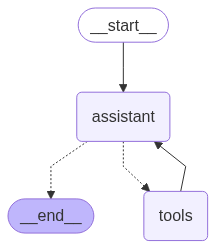

In [21]:
# To see the graph’s connection visually

display(Image(react_graph.get_graph().draw_mermaid_png()))

## Testing Multi-Tool Agent Capabilities

Test the agent with a complex query requiring multiple tools:
1. **Web search**: Get weather information for Delhi
2. **Mathematical operations**: Multiply result by 2, then add 5
3. **Workflow coordination**: Chain multiple tool calls seamlessly

This demonstrates the agent's ability to break down complex tasks and use appropriate tools in sequence.

In [24]:
response = react_graph.invoke({"messages": [HumanMessage(content="what is the weather in Galle, Sri Lanka. Multiply it by 2 and add 5.")]})
print(response["messages"])

[HumanMessage(content='what is the weather in Galle, Sri Lanka. Multiply it by 2 and add 5.', additional_kwargs={}, response_metadata={}, id='95101eb3-66f3-4e97-841c-de96df48e4cb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_dAmrRjRFbj3vxQehcXUcytqB', 'function': {'arguments': '{"query":"weather in Galle, Sri Lanka"}', 'name': 'search_duckduckgo'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 115, 'total_tokens': 138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_c4c155951e', 'id': 'chatcmpl-C9izPJS1U5N0WQFH86f6GH2enOgZ0', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--809a1a66-ac32-4251-b926-b86adb2faecc-0', tool_calls=[{'name'

In [25]:
import pandas as pd
pd.DataFrame([msg.__dict__ for msg in response["messages"]])

,content,additional_kwargs,response_metadata,type,name,id,example,tool_calls,invalid_tool_calls,usage_metadata,tool_call_id,artifact,status
0,"what is the weather in Galle, Sri Lanka. Multi...",{},{},human,None,95101eb3-66f3-4e97-841c-de96df48e4cb,False,NaN,NaN,NaN,NaN,NaN,NaN
1,,{'tool_calls': [{'id': 'call_dAmrRjRFbj3vxQehc...,"{'token_usage': {'completion_tokens': 23, 'pro...",ai,None,run--809a1a66-ac32-4251-b926-b86adb2faecc-0,False,"[{'name': 'search_duckduckgo', 'args': {'query...",[],"{'input_tokens': 115, 'output_tokens': 23, 'to...",NaN,NaN,NaN
2,The Weather Channel 10-Day Weather Forecast fo...,{},{},tool,search_duckduckgo,41875559-225b-49f6-881d-04810a238cc7,NaN,NaN,NaN,NaN,call_dAmrRjRFbj3vxQehcXUcytqB,NaN,success
3,,{'tool_calls': [{'id': 'call_wSSyxcTJb4hhzFPgj...,"{'token_usage': {'completion_tokens': 24, 'pro...",ai,None,run--2863e63b-a5bf-43b0-824f-fe3e3ca6b0f7-0,False,"[{'name': 'search_duckduckgo', 'args': {'query...",[],"{'input_tokens': 379, 'output_tokens': 24, 'to...",NaN,NaN,NaN
4,Current Weather in Galle Sri Lanka Day 2: Gall...,{},{},tool,search_duckduckgo,d4532b74-af29-4a9f-b30e-24cd4f4b2af2,NaN,NaN,NaN,NaN,call_wSSyxcTJb4hhzFPgjVpM1WYy,NaN,success
5,,{'tool_calls': [{'id': 'call_6eWQxuf5ycr1y50bu...,"{'token_usage': {'completion_tokens': 65, 'pro...",ai,None,run--5fdfbe22-b54d-4daa-b6de-13f808c1f23e-0,False,"[{'name': 'search_duckduckgo', 'args': {'query...",[],"{'input_tokens': 602, 'output_tokens': 65, 'to...",NaN,NaN,NaN
6,Galle - Wikipedia Galle is a major city on the...,{},{},tool,search_duckduckgo,2b604af6-1dbb-47d6-8b25-0653c9c8e837,NaN,NaN,NaN,NaN,call_6eWQxuf5ycr1y50bu8Ri2XbQ,NaN,success
7,Galle - Wikipedia Galle is a major city on the...,{},{},tool,search_duckduckgo,dbe75886-698b-46ca-b4be-5a800989f9f1,NaN,NaN,NaN,NaN,call_1jfGfeAzzvSP85b0ozGAqcFZ,NaN,success
8,"The current temperature in Galle, Sri Lanka is...",{'tool_calls': [{'id': 'call_QYc4GXy47vNaDIDjX...,"{'token_usage': {'completion_tokens': 82, 'pro...",ai,None,run--95f2c24d-b50d-468c-8501-f0e9a2fe117f-0,False,"[{'name': 'multiply', 'args': {'a': 29, 'b': 2...",[],"{'input_tokens': 1206, 'output_tokens': 82, 't...",NaN,NaN,NaN
9,58,{},{},tool,multiply,d5e9143e-e21c-4dd5-afdb-c1b1152bec26,NaN,NaN,NaN,NaN,call_QYc4GXy47vNaDIDjXVQte2RZ,NaN,success


In [27]:
response['messages'][-1].content

'The result of multiplying the current temperature (29°C) by 2 is 58, and after adding 5, the total is 34.'

## Additional Testing

To do: Address the issue of chaining addition to the multiplied result.

In [37]:
response = react_graph.invoke({"messages": [HumanMessage(content="what is the weather in Sri Lanka. Multiply it by 2 and add 5.")]})
print(response["messages"])

[HumanMessage(content='what is the weather in Sri Lanka. Multiply it by 2 and add 5.', additional_kwargs={}, response_metadata={}, id='93778cd2-9067-49b4-bcc7-655b27faadac'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rDLO1vqnCHExEtyFuTL6ntVC', 'function': {'arguments': '{"query":"current weather in Sri Lanka"}', 'name': 'search_duckduckgo'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 112, 'total_tokens': 133, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_c4c155951e', 'id': 'chatcmpl-C9jGYVBxPsWLIoApf7ZZ9ISqNhSFS', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--002fcb44-0d34-4e2f-bc36-606fb5fbce25-0', tool_calls=[{'name': 'sea

In [38]:
pd.DataFrame([msg.__dict__ for msg in response["messages"]])

,content,additional_kwargs,response_metadata,type,name,id,example,tool_calls,invalid_tool_calls,usage_metadata,tool_call_id,artifact,status
0,what is the weather in Sri Lanka. Multiply it ...,{},{},human,None,93778cd2-9067-49b4-bcc7-655b27faadac,False,NaN,NaN,NaN,NaN,NaN,NaN
1,,{'tool_calls': [{'id': 'call_rDLO1vqnCHExEtyFu...,"{'token_usage': {'completion_tokens': 21, 'pro...",ai,None,run--002fcb44-0d34-4e2f-bc36-606fb5fbce25-0,False,"[{'name': 'search_duckduckgo', 'args': {'query...",[],"{'input_tokens': 112, 'output_tokens': 21, 'to...",NaN,NaN,NaN
2,Sri Lanka Current Weather | AccuWeather Get th...,{},{},tool,search_duckduckgo,91421516-9a3e-4b51-a351-875787ab399e,NaN,NaN,NaN,NaN,call_rDLO1vqnCHExEtyFuTL6ntVC,NaN,success
3,,{'tool_calls': [{'id': 'call_nft2m8Qtpv0f7Z36D...,"{'token_usage': {'completion_tokens': 58, 'pro...",ai,None,run--6325b067-a42a-4609-b8b0-f4342de6a523-0,False,"[{'name': 'search_duckduckgo', 'args': {'query...",[],"{'input_tokens': 294, 'output_tokens': 58, 'to...",NaN,NaN,NaN
4,"10-Day Weather Forecast for Galle, Galle, Sri ...",{},{},tool,search_duckduckgo,599af208-bec7-45a4-87d6-17a8b20aaa06,NaN,NaN,NaN,NaN,call_nft2m8Qtpv0f7Z36Dgs248Jb,NaN,success
5,AccuWeather Sri Lanka Current Weather | AccuWe...,{},{},tool,search_duckduckgo,85ecd4f9-73b0-45e1-a52f-037535369609,NaN,NaN,NaN,NaN,call_hfpyStivglMZL3yt9qXaukLT,NaN,success
6,The current temperature in Sri Lanka varies ac...,{'tool_calls': [{'id': 'call_dMCNCrAc5cfTbu4vI...,"{'token_usage': {'completion_tokens': 117, 'pr...",ai,None,run--29f97f3d-2b89-40b2-9d4b-10fd58a80860-0,False,"[{'name': 'multiply', 'args': {'a': 88.5, 'b':...",[],"{'input_tokens': 1035, 'output_tokens': 117, '...",NaN,NaN,NaN
7,Error: 1 validation error for multiply\na\n I...,{},{},tool,multiply,b53150c2-0535-475c-86aa-ca2fa8eaf4ce,NaN,NaN,NaN,NaN,call_dMCNCrAc5cfTbu4vINkmRNvP,NaN,error
8,Error: 1 validation error for add\na\n Input ...,{},{},tool,add,afddf1b7-fa3b-4fd6-b168-09a1f7339559,NaN,NaN,NaN,NaN,call_gENaeI0TF7XVqZfNzl2j56l6,NaN,error
9,The temperature values should be integers for ...,{'tool_calls': [{'id': 'call_n5rrdpS6X9GBBg2MC...,"{'token_usage': {'completion_tokens': 78, 'pro...",ai,None,run--0e9696d6-6f74-4036-a156-3e33646049f1-0,False,"[{'name': 'multiply', 'args': {'a': 89, 'b': 2...",[],"{'input_tokens': 1308, 'output_tokens': 78, 't...",NaN,NaN,NaN


In [39]:
response['messages'][-1].content

'After rounding the average temperature to 89°F, multiplying it by 2 gives 178, and adding 5 results in 94.'